# Introduction

This notebook processes legal document data from the DOCLEG database to construct a hierarchical document graph. The graph organizes nodes into four levels—acts, articles, sequences, and text chunks—and uses bidirectional and sequential links to capture both contextual connections and temporal progressions among the documents.

Starting with several CSV tables exported directly from the DOCLEG database, the main output is a base document graph stored as a networkx graph in a .pkl file.

In subsequent notebooks, this base graph will be enriched by incorporating additional entities and relationships that extend beyond its initial hierarchical and temporal structure.

## 0. Import dependencies

In [1]:
# Standard library imports
import os
import pickle
import sys

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Determine the project root directory for relative imports
try:
    # This will work in scripts where __file__ is defined
    current_dir = os.path.dirname(os.path.abspath(__file__))
    # Assuming "src" is parallel to the script folder
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
except NameError:
    # In notebooks __file__ is not defined: assume we're in notebooks/riziv_dataset/
    project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Local application imports

from riziv.riziv_article_code_format_utils import (
    standardize_article_number,
    std_to_sort_tuple,
)
from riziv.riziv_graph_building_utils import create_base_document_graph
from riziv.riziv_graph_visualization_utils import (
    visualize_node_1hop,
    visualize_node_2hop,
)

from riziv.riziv_sequence_chunking_utils import (
    split_text_with_overlap,
    verify_overlap,
)

## 1. Loading the data

For the hackathon, instead of directly querying the DOCLEG database, the relevant tables were exported from the DOCLEG database in '.csv' format to be imported and handled as pandas data frames. This includes the following 6 tables:

- _WorkActPlusLanguageFR_: Join of the "WorkAct" and the "WorkActLanguage" tables from the DOCLEG database containing all non-language related information about acts as well as language information (Act title, Act title short etc.) in french (FR).

- _WorkArticlePlusLanguageFR_: Join of the "WorkArticle" and the "WorkArticleLanguage" tables from the DOCLEG database containing all non-language related information about articles as well as language information (Article title etc.) in french (FR).

- _segmentPlusLanguageFR_: Join of the "Segment" and the "SegmentLanguage" tables from the DOCLEG database containing all non-language related information about text segments as well as the text of the segments themselves in french (FR).

- _sequence_TOCFiltered_: Subset of the table "Sequence" from the DOCLEG database containing only the information about sequences associated to articles, that is, excluding all sequences related to tables of contents (Hence TOC filtered).

- _sequence_: Unfiltered "Sequence" table from the DOCLEG database.

- _sequence_SQE_: Table "SequenceEntry" from the DOCLEG database containing the relevant information to map segments to their corresponding sequences.


In [2]:
# Define the path to the RIZIV dataset files
RIZIV_data_path = os.path.join(project_root, "data", "RIZIV_hackathon_main")

# Load all previously processed and saved DataFrames (from load_data.py)
workActPlusLanguageFR = pd.read_csv(os.path.join(RIZIV_data_path, 'df_workActPlusLanguageFR.csv'))
workArticlePlusLanguageFR = pd.read_csv(os.path.join(RIZIV_data_path, 'df_workArticlePlusLanguageFR.csv'))
segmentPlusLanguageFR = pd.read_csv(os.path.join(RIZIV_data_path, 'df_segmentPlusLanguageFR.csv'))
sequence_TOCFiltered = pd.read_csv(os.path.join(RIZIV_data_path, 'df_sequence_TOCFiltered.csv'))
sequence = pd.read_csv(os.path.join(RIZIV_data_path, 'df_sequence.csv'))
sequence_SQE = pd.read_csv(os.path.join(RIZIV_data_path, 'df_sequence_SQE.csv'))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14312\481875423.py:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  sequence_SQE = pd.read_csv(os.path.join(RIZIV_data_path, 'df_sequence_SQE.csv'))


## 2. Sequences re-construction

Due to their typical length and context within the broader DOCLEG database, sequences were condisered too granular and isolated units of text/informations to be the primary subjects of relevance assessment for the proposed RAG pipeline during the hackathon. Thus, as a first step towards building the document graph, the sequences as conceived in the DOCLEG database are re-constructed from their constituent text segments by retrieving and concatenating these in and orderly manner. Subsequently, these re-constructed sequences are formatted into a DataFrame (sequence_collection_df) for that will serve as basis for the creation of "sequence" nodes un the document graph. At this point, sequence_collection_df contains both types of sequences "VIG" and "PUB".

In [3]:
sequence_collection = {}
incidences = []

# For each defined sequence of segments... (Iterate over table sequence)
for seq, seq_act, seq_article, type_seq, date_seq in sequence_TOCFiltered[['Id', "IdAct", "IdArticle", "Type", "Date"]].itertuples(index=False): 

    # Define a list to store the text of the sequence
    sequence_text = []

    # Get the entries of the sequence
    sequence_entries = sequence_SQE[sequence_SQE['SequenceId'] == seq]

    # For each entry/segment of the sequence...
    for entry, rank in sequence_entries[['SegmentId', 'Rank']].itertuples(index=False):

        # Check if the segment exists in the segmentPlusLanguageFR table
        if (segmentPlusLanguageFR['SegmentId'] == entry).any():

            # Get the prefix of the segment
            sequence_text_prefix = segmentPlusLanguageFR[segmentPlusLanguageFR['SegmentId'] == entry]['Prefix'].values[0]

            # If the prefix is not NaN, add it to the sequence text
            if sequence_text_prefix is not np.nan:
                sequence_text.append(str(sequence_text_prefix))

            # Get the main text of the segment
            sequence_text_main = segmentPlusLanguageFR[segmentPlusLanguageFR['SegmentId'] == entry]['Title'].values[0]

            # If the main text is not NaN, add it to the sequence text
            if sequence_text_main is not np.nan:
                sequence_text.append(str(sequence_text_main))

        # If the segment does not exist in the segmentPlusLanguageFR table, add it to the incidences list and continue to the next segment
        else:
            incidences.append({'sequence': seq, 'segment': entry})

    # Join the sequence text into a single string
    final_sequence_text = "\n".join(sequence_text)

    # Add the sequence text to the sequence collection, alongside with the type and date of the sequence
    sequence_collection[seq] = {'text': final_sequence_text, 'type': type_seq, 'date': date_seq, 'act': seq_act, 
                                'article': seq_article, 'rank': rank}
    
print("Number of incidences during the sequence building process: ", len(incidences))
print("Number of sequences constructed: ", len(sequence_collection))

# Create a DataFrame from the sequence collection
sequence_collection_df = pd.DataFrame(sequence_collection).T

# Convert columns to the correct types
sequence_collection_df['date'] = pd.to_datetime(sequence_collection_df['date'])
sequence_collection_df['act'] = sequence_collection_df['act'].astype(int)
sequence_collection_df['article'] = pd.to_numeric(sequence_collection_df['article'], errors='coerce').astype('Int64')

# Keep the same temporal structure without replacing NaT with future date
sequence_collection_df = sequence_collection_df.rename(columns={'date': 'date_start'})
sequence_collection_df['date_end'] = sequence_collection_df.sort_values('date_start').groupby(['article', 'type'])['date_start'].shift(-1)

# Create new 'prefix' column with text up to the first line break
sequence_collection_df['prefix'] = sequence_collection_df['text'].str.split('\n').str[0]

# Create a mapping dictionary from workArticlePlusLanguageFR to retrieve article number/codes and assign it as a new feature
article_number_map = dict(zip(workArticlePlusLanguageFR['Id'], workArticlePlusLanguageFR['Number']))
sequence_collection_df['article_number'] = sequence_collection_df['article'].map(article_number_map)

# Apply function to standardize article number and create sort_tuple
sequence_collection_df['article_number_std'] = sequence_collection_df['article_number'].apply(standardize_article_number)
sequence_collection_df['sort_tuple'] = sequence_collection_df['article_number_std'].apply(std_to_sort_tuple)

print("Shape of the sequence collection DataFrame: ", sequence_collection_df.shape)

# Save the dataframe containing the collection of all re-constructed sequences.
sequence_collection_df.to_csv(os.path.join(RIZIV_data_path, 'df_sequences_collection.csv'))

Number of incidences during the sequence building process:  18
Number of sequences constructed:  31941
Shape of the sequence collection DataFrame:  (31941, 11)


In [4]:
# Visualize the final result (optional)
#sequence_collection_df.sample(5)

### 2.1 Sanity checking sequence construction: Retrieving Acts at a given point in time

In the DOCLEG database, a sequence typically represents an Article within an Act at a given point in time. Thus, an interesting way of sanity-checking the results of the sequence building procedure to display the entire text of an Act at a given point in time, retrieving all the sequences that were in force at an specified moment.

In [5]:
# Helper function to filter valid nodes (articles) at a specific date
def get_valid_nodes_at_date(df, target_date, article_type='VIG'):
    """
    Gets the nodes (article versions) valid at a specific date
    
    Args:
        df: DataFrame with nodes
        target_date: target date to check
        article_type: 'VIG' for in force, 'PUB' for published
    Returns:
        DataFrame with valid nodes at that date
    """
    target_date = pd.to_datetime(target_date)
    mask = (
        (df['type'] == article_type) & 
        (df['date_start'] <= target_date) & 
        ((df['date_end'].isna()) | (df['date_end'] > target_date))
    )
    return df[mask]

In [6]:
# Filter by IdAct and order by sort_tuple (500001 = Loi coordonnée du 14-7-1994)
time_filtered_df = sequence_collection_df[sequence_collection_df['act'] == 500499].sort_values(
    by='sort_tuple',
    )

# Filtering by date
result = get_valid_nodes_at_date(time_filtered_df, '2025-03-29', article_type='VIG')

# Join all sequences to build the full text
full_text = '\n\n'.join(result['text'].tolist())
print(full_text)

Article 1er.
L'attestation de soins ou de fournitures, ou le document qui en tient lieu, doit être remis par le dispensateur de soins au bénéficiaire ou à l'organisme assureur au plus tard dans un délai de deux mois suivant la fin du mois au cours duquel les prestations ont été fournies.
Toutefois, lorsque la facturation trimestrielle est admise en vertu des dispositions réglementaires, le délai prévu à l'alinéa 1er prend cours à la fin du trimestre auquel se rapporte la facture.
Si, dans les conventions et accords visés au titre III, chapitre V, de la loi précitée, un délai a été fixé pour la remise de l'attestation de soins ou de fournitures ou le document qui en tient lieu, ce délai reste d'application jusqu'à la date d'expiration des conventions et accords précitées.
Toute convention et tout accord conclu après l'entrée en vigueur du présent arrêté devra se conformer au délai prévu à l'alinéa 1er.

Art. 2.
Les constatations qui sont de nature à établir une infraction visée à l'[:C 

## 3. Sequence's text chunking

The idea behind the proposed RAG system behind for the DOCLEG database is to provide an LLM with the relevant legal evidence from DOCLEG to answer a given query. While the text segments were considered too short and granular to comprise the primary units of relevant evidence for the system to retrieve, sequences display more adequate properties to occupy that role. A close exploration of these reveal that most of them have a relatively moderate length which would allow an LLM to work with them efficiently when included in a prompt. However there is a subset of sequences whose length can exceed the equivalent of some to tens of pages. These may be more costly and difficult to handle for an LLM, specially considereing that multiple of such pices of evidence are intended to be included in a single prompt to answer a query. As a result of this, a sequence's text chunking is approach is adopted, where the sequence's text is split into chunks of "N" characters with an overlap of "d" characters between the preceeding and following one. For the hackathon these values where set at 4000 characters of length and 250 characters of overlap, with 4000 characters being roughly equivalent to a document of 3-4 pages which sits arouned the 90th percentile within the distribution of sequence's length. For the protoype proposed at the hackathon, these text chunks/fragments within sequences are the pieces of evidence whose relevance is assessed and provided to the LLM en charge to generating the final answer alongside the user query. It is worth noting that with the character length value chosen for the hackathon around 90% of sequences will remain intact after the chunking procedure, with only the top 10% lengthiest ones being subject to this procedure.

In [7]:
# Load data
sequence_collection_df = pd.read_csv(os.path.join(RIZIV_data_path, 'df_sequences_collection.csv'), 
                                   parse_dates=['date_start', 'date_end'])
sequence_collection_df = sequence_collection_df.rename(columns={'Unnamed: 0': 'sequence_id'})

### 3.1 Exploring sequence text length


Descriptive Statistics:
Count: 31,915
Mean: 2,292.7
Standard Deviation: 12,455.9

Percentiles:
Minimum: 6
25th percentile: 201
Median: 600
75th percentile: 1,656
85th percentile: 2,894
90th percentile: 4,321
95th percentile: 7,855
99th percentile: 27,827
Maximum: 1,031,669

Articles above 99th percentile: 320 (1.00% of total)

Additional Statistics:
Mode: 63
Skewness: 50.28
Kurtosis: 3536.37


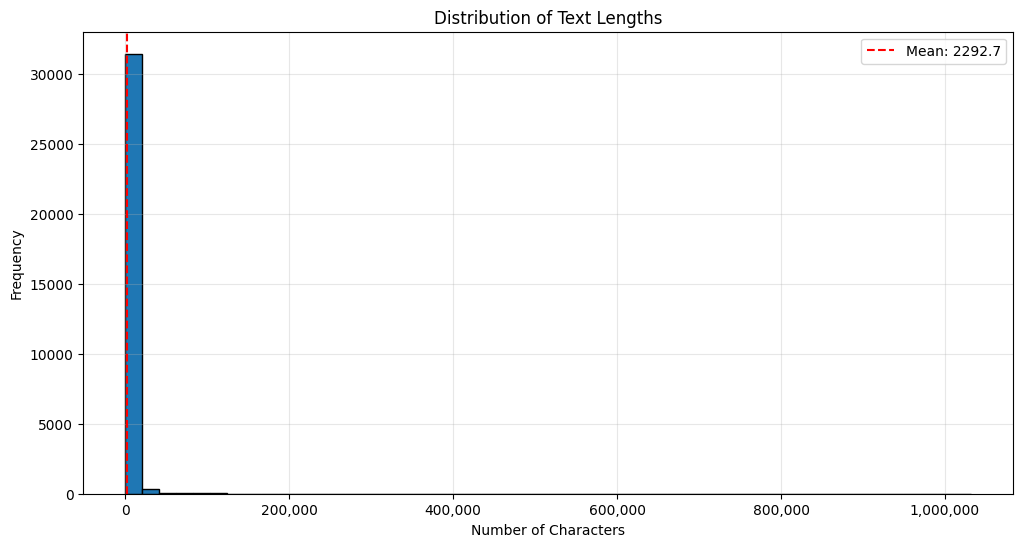

In [8]:
# Add new column 'text_length' to the sequence's dataframe capturing with the number of characters within a sequence's text
sequence_collection_df['text_length'] = sequence_collection_df['text'].str.len()

# Plotting the distribution of this new 'text_length' attribute for inspection alongside descriptive statistics...

# Create figure and axes
plt.figure(figsize=(12, 6))

# Create histogram
plt.hist(sequence_collection_df['text_length'], bins=50, edgecolor='black')

# Customize the plot
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Add vertical line with mean
mean = sequence_collection_df['text_length'].mean()
plt.axvline(x=mean, color='red', linestyle='--', label=f'Mean: {mean:.1f}')

# Format x-axis to show full numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add legend
plt.legend()

# Show grid
plt.grid(True, alpha=0.3)

# Calculate descriptive statistics
stats = sequence_collection_df['text_length'].describe()
additional_percentiles = sequence_collection_df['text_length'].quantile([.85, .90, .95, .99])  # Added .90

# Calculate number of articles above 99th percentile
p99_value = additional_percentiles[0.99]
articles_above_p99 = len(sequence_collection_df[sequence_collection_df['text_length'] > p99_value])
total_articles = len(sequence_collection_df)

# Print detailed statistics
print("\nDescriptive Statistics:")
print(f"Count: {stats['count']:,.0f}")
print(f"Mean: {stats['mean']:,.1f}")
print(f"Standard Deviation: {stats['std']:,.1f}")
print("\nPercentiles:")
print(f"Minimum: {stats['min']:,.0f}")
print(f"25th percentile: {stats['25%']:,.0f}")
print(f"Median: {stats['50%']:,.0f}")
print(f"75th percentile: {stats['75%']:,.0f}")
print(f"85th percentile: {additional_percentiles[0.85]:,.0f}")
print(f"90th percentile: {additional_percentiles[0.90]:,.0f}")  # Added 90th percentile
print(f"95th percentile: {additional_percentiles[0.95]:,.0f}")
print(f"99th percentile: {additional_percentiles[0.99]:,.0f}")
print(f"Maximum: {stats['max']:,.0f}")

print(f"\nArticles above 99th percentile: {articles_above_p99:,} ({(articles_above_p99/total_articles)*100:.2f}% of total)")

# Calculate additional statistics
print(f"\nAdditional Statistics:")
print(f"Mode: {sequence_collection_df['text_length'].mode().iloc[0]:,.0f}")
print(f"Skewness: {sequence_collection_df['text_length'].skew():.2f}")
print(f"Kurtosis: {sequence_collection_df['text_length'].kurtosis():.2f}")

plt.show()

In [9]:
# Exploratory exercise: Find the row/sequence with the longest text
longest_article = sequence_collection_df.loc[sequence_collection_df['text_length'].idxmax()]

print(f"Longest article:")
print(f"Article number: {longest_article['article_number']}")
print(f"Length: {longest_article['text_length']} characters")
print(f"Prefix: {longest_article['prefix']}")
print("\nComplete text:")
print("="*80)  # Separator line
print(longest_article['text'])
print("="*80)  # Separator line

Longest article:
Article number: 8191
Length: 1031669.0 characters
Prefix: Art. 191.

Complete text:
Art. 191.
Les ressources de l'assurance sont constituées par :
6°
les dons et legs, destinés à l'assurance soins de santé et indemnités, acceptés par le Comité général de l'Institut ou par le Ministre;
8°
le produit d'un supplément de cotisation ou de prime d'assurance de la responsabilité civile régie par la loi du 21 novembre 1989 relative à l'assurance obligatoire de la responsabilité civile en matière de véhicules automoteurs, perçu par les assureurs compétents en la matière et par le Fonds commun de garantie visé à l'article 49 de la loi du 9 juillet 1975 relative au contrôle des entreprises d'assurances et le produit d'un supplément de cotisation ou de prime d'assurance corps de véhicules automoteurs.
Ce supplément est fixé à 10 p.c. de la cotisation ou de la prime. Dans les conditions à fixer par le Roi, ce pourcentage est ramené à 5 p.c. pour les catégories, à déterminer par Lui

In [10]:
longest_article

sequence_id                                                    12034896
text                  Art. 191.\nLes ressources de l'assurance sont ...
type                                                                VIG
date_start                                          2017-05-01 00:00:00
act                                                              500001
article                                                         1500191
rank                                                                  9
date_end                                            2017-09-07 00:00:00
prefix                                                        Art. 191.
article_number                                                     8191
article_number_std                                          8191.00.000
sort_tuple                                                  (191, 0, 0)
text_length                                                   1031669.0
Name: 25477, dtype: object

4000 characters ~ 90th percentile

In [11]:
# Calculate the 90th percentile value
p90_value = sequence_collection_df['text_length'].quantile(0.90)

# Find the article closest to the 90th percentile
closest_to_p90 = sequence_collection_df.loc[(sequence_collection_df['text_length'] - p90_value).abs().idxmin()]

print(f"Article close to 90th percentile:")
print(f"Article number: {closest_to_p90['article_number']}")
print(f"Length: {closest_to_p90['text_length']} characters")
print(f"Prefix: {closest_to_p90['prefix']}")
print(f"Exact value of 90th percentile: {p90_value:.0f} characters")
print("\nComplete text:")
print("="*80)  # Separator line
print(closest_to_p90['text'])
print("="*80)  # Separator line

Article close to 90th percentile:
Article number: 8035
Length: 4322.0 characters
Prefix: Art. 35.
Exact value of 90th percentile: 4321 characters

Complete text:
Art. 35.
§ 1er.
Le Roi établit la nomenclature des prestations de santé.
Cette nomenclature énumère lesdites prestations, en fixe la valeur relative et précise, notamment, ses règles d'application, ainsi que la qualification requise de la personne habilitée à effectuer chacune d'elles. Le cas échéant, des tarifs différents peuvent être appliqués pour une même prestation selon que le dispensateur de soins répond ou non à des conditions supplémentaires, autres que celles relatives à la qualification, telles que prévues dans la nomenclature. La nomenclature des prestations visées à l'[:C 1]article 34, 4°[:c], pour autant qu'il s'agisse des implants, 5° et 20°, est fixée sur base des critères d'admission définis par le Roi et selon lesquels ces prestations peuvent être divisées en différentes catégories. Ces critères d'admission c

### 3.2 Chunking

In [12]:
# Initialize empty lists to store chunk information
new_texts = []          # Will store the actual text chunks
original_indices = []    # Will store the index from original DataFrame
chunk_indices = []      # Will store the position of chunk within its original text
sort_tuples = []        # Will store the sort_tuple from original sequence
acts = []              # Will store the act from original sequence
sequence_ids = []

# Process each row in the original DataFrame
for idx, row in sequence_collection_df.iterrows():
    try:
        # Split the text into chunks with overlap
        chunks = split_text_with_overlap(row['text'], chunk_size=4000, overlap=250)
        
        # Store information for each chunk
        for chunk_idx, chunk in enumerate(chunks):
            new_texts.append(chunk)
            original_indices.append(idx)        # Keep track of source text
            chunk_indices.append(chunk_idx)     # Keep track of chunk position
            sort_tuples.append(row['sort_tuple'])  # Add sort_tuple from original sequence
            acts.append(row['act'])               # Add act from original sequence
            sequence_ids.append(row['sequence_id'])       # Add sequence_id from original sequence
    except Exception as e:
        print(f"Error processing row {idx}: {str(e)}")

# Create new DataFrame with the chunks and their metadata
chunks_df = pd.DataFrame({
    'text': new_texts,
    'original_index': original_indices,
    'chunk_index': chunk_indices,
    'sort_tuple': sort_tuples,
    'act': acts,
    'sequence_id': sequence_ids
})

# Add column with length of each chunk for verification
chunks_df['text_length'] = chunks_df['text'].str.len()

# Print basic statistics about the chunking process
print("Original number of texts:", len(sequence_collection_df))
print("Number of chunks created:", len(chunks_df))
print("\nChunk length statistics:")
print(chunks_df['text_length'].describe())

# Verify overlap between consecutive chunks
verify_overlap(chunks_df)

# Include time prevalence information of sequence to chunks

# Create a mapping of original indices to their dates
date_mapping = sequence_collection_df[['date_start', 'date_end']].to_dict('index')

# Add date columns using original_index for mapping
chunks_df['date_start'] = chunks_df['original_index'].map(lambda x: date_mapping[x]['date_start'])
chunks_df['date_end'] = chunks_df['original_index'].map(lambda x: date_mapping[x]['date_end'])

# Verify the result
print("First rows of updated DataFrame:")
print(chunks_df[['text', 'original_index', 'chunk_index', 'date_start', 'date_end']].head())

# Save the dataframe containing the collection of all sequence's text chunks.
chunks_df.to_csv(os.path.join(RIZIV_data_path, 'df_sequence_text_chunks.csv'), index=False)

Original number of texts: 31941
Number of chunks created: 43436

Chunk length statistics:
count    43436.000000
mean      1750.717700
std       1585.221621
min          3.000000
25%        321.000000
50%       1064.000000
75%       4000.000000
max       4000.000000
Name: text_length, dtype: float64

Overlap verification completed. Found 0 errors.
First rows of updated DataFrame:
                                                text  original_index  \
0  Article 1.\nLa présente loi coordonnée institu...               0   
1  Art. 3.\nSont agréées pour l'application des d...               1   
2  Art. 4.\nL'agréation peut être retirée par le ...               2   
3  Art. 5.\nLa Caisse auxiliaire d'assurance mala...               3   
4  Art. 6.\nLa "Caisse des soins de santé" de la ...               4   

   chunk_index date_start   date_end  
0            0 1994-08-27 2012-12-31  
1            0 1994-08-27        NaT  
2            0 1994-08-27        NaT  
3            0 1994-08-27 201

In [13]:
# Visualize the final result (optional)
#chunks_df.sample(5)

# Note: date_end = NaT -> The text is prevalent to the present day

## 4. Building base document graph

Having completed the previous steps, the base document graph is built following the implicit hierarchical structure of the documents on the DOCLEG databased divided in four levels: "acts", "articles", "sequences", and "text_chunks". At the highest level, act nodes are connected bidirectionally to their constituent article nodes, which encapsulate the persistent concept of an article over time. Each article node is then linked via bidirectional edges to a number of sequence nodes, each representing a specific version of the article text at a given time point. Finally, sequence nodes branch into text chunk nodes, which denote ordered fragments of the sequence's text; these chunks not only link back to their parent sequence but also form bidirectional sequential links with adjacent chunks using "followed_by" and "preceded_by" relationships.

### 4.1 Document Graph Building

In [14]:
# Load the sequences and chunks DataFrames from CSV files with date parsing

sequence_collection_df = pd.read_csv(os.path.join(RIZIV_data_path,'df_sequences_collection.csv'), 
                                   parse_dates=['date_start', 'date_end'])
sequence_collection_df = sequence_collection_df.rename(columns={'Unnamed: 0': 'sequence_id'})

chunks_df = pd.read_csv(os.path.join(RIZIV_data_path,'df_sequence_text_chunks.csv'),
                        parse_dates=['date_start', 'date_end'])

workArticlePlusLanguageFR = pd.read_csv(os.path.join(RIZIV_data_path,'df_workArticlePlusLanguageFR.csv'))

workActPlusLanguageFR = pd.read_csv(os.path.join(RIZIV_data_path,'df_workActPlusLanguageFR.csv'))

# Create the graph
graph = create_base_document_graph(sequence_collection_df, chunks_df, workArticlePlusLanguageFR, workActPlusLanguageFR)

# Save the base document graph
with open(os.path.join(RIZIV_data_path,'base_document_graph.pkl'), 'wb') as f:
    pickle.dump(graph, f)

Adding act nodes...
Adding article nodes and act relationships...
Adding sequence nodes and article relationships...
Adding chunk nodes and their relationships...

Graph Statistics:
Total number of nodes: 85767
Total number of edges: 192232
Number of article nodes: 9244
Number of sequence nodes: 31941
Number of chunk nodes: 43436

Edge Statistics:
contains_article edges: 9244
belongs_to_act edges: 9244
has_version edges: 31941
version_of edges: 31941
contains_chunk edges: 43436
contained_in_sequence edges: 43436
followed_by edges: 11495
preceded_by edges: 11495


### 4.2 Visualizing and evaluating the base document graph

In [15]:
# Select random nodes of each type
random_act = f"act_{workActPlusLanguageFR['Id'].sample(1).iloc[0]}"
random_article = f"article_{workArticlePlusLanguageFR['Id'].sample(1).iloc[0]}"
random_sequence = f"sequence_{sequence_collection_df['sequence_id'].sample(1).iloc[0]}"

# For chunks, we need to select a random row and use both columns
random_chunk_row = chunks_df[['sequence_id', 'chunk_index']].sample(1).iloc[0]
random_chunk = f"chunk_{random_chunk_row['sequence_id']}_{random_chunk_row['chunk_index']}"

In [16]:
# Overview of a random Act node
node_id = random_act
print(graph.nodes[node_id])

{'type_node': 'act', 'Id': 500928, 'TypeDocument': 'AR', 'DateDocument': '2018-01-28', 'FirstEntryInForce': '2018-02-23', 'DateNoLongerInForce': nan, 'DatePublication': '2018-02-13', 'Title': "Arrêté royal du 28 janvier 2018 octroyant une dotation au Centre fédéral d'expertise des soins de santé pour l'année 2018", 'TitleShort': "A.R. 28-1-2018: dotation au Centre fédéral d'expertise des soins de santé pour l'année 2018"}


In [17]:
# Overview of a random Article node
node_id = random_article
print(graph.nodes[node_id])

{'type_node': 'article', 'article': 1502426, 'article_number_std': '8001.00.000', 'sort_tuple': '(1, 0, 0)', 'act': 500199}


In [18]:
# Overview of a random Sequence node
node_id = random_sequence
print(graph.nodes[node_id])

{'sequence_id': 4000013, 'text': "Art. 8.\nLes informations visées à l'[:C 1]article 7[:c], obtenues auprès du Registre national des personnes physiques et consignées sur une fiche d'identification versée au dossier, font foi jusqu'à preuve du contraire.\nLe Roi fixe les conditions et modalités de conservation de ces informations, pour certifier l'origine et la date à laquelle elles font foi.\nLorsque la preuve du contraire visée à l'alinéa 1er est acceptée par l'organisme concerné, celui-ci communique le contenu de l'information ainsi acceptée, à titre de renseignement, au Registre national des personnes physiques en y joignant les documents justificatifs.", 'type': 'PUB', 'date_start': Timestamp('1994-08-27 00:00:00'), 'act': 500001, 'article': 1500008, 'rank': 4, 'date_end': NaT, 'prefix': 'Art. 8.', 'article_number': '8008', 'article_number_std': '8008.00.000', 'sort_tuple': '(8, 0, 0)', 'type_node': 'sequence'}


In [19]:
# Overview of a random Chunk node
node_id = random_chunk
print(graph.nodes[node_id])

{'text': "Art. 23ter.\nL'examen médical doit être effectué dans les trente jours ouvrables à compter de la constatation, par l'organisme assureur, de l'activité non autorisée ou à compter de la communication de celle-ci à l'organisme assureur.\nLes jours ou la période visés à l'alinéa précédent sont assimilés à des jours indemnisés pour la détermination des droits aux prestations de sécurité sociale du titulaire ainsi que des personnes à charge de celui-ci.\n§ 1er.\nLe titulaire reconnu incapable de travailler, qui a effectué un travail sans l'autorisation préalable visée aux articles [:A] 23 et 23bis, ou sans avoir respecté les conditions de l'autorisation, est soumis à un examen médical en vue de contrôler si les conditions de reconnaissance de l'incapacité de travail sont réunies à la date de l'examen.\n§ 2.\nLe titulaire visé au § 1er est tenu de rembourser les indemnités d'incapacité de travail qu'il a perçues pour les jours ou la période durant lesquels il a effectué le travail n

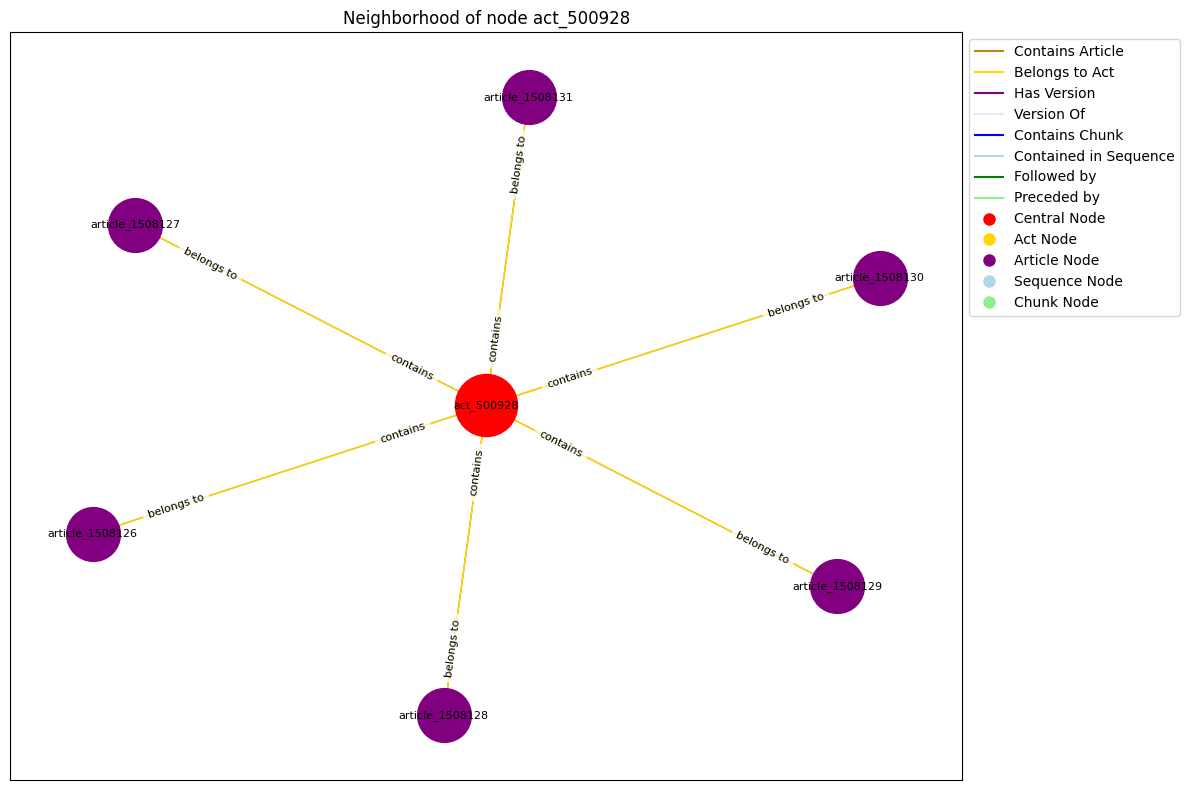

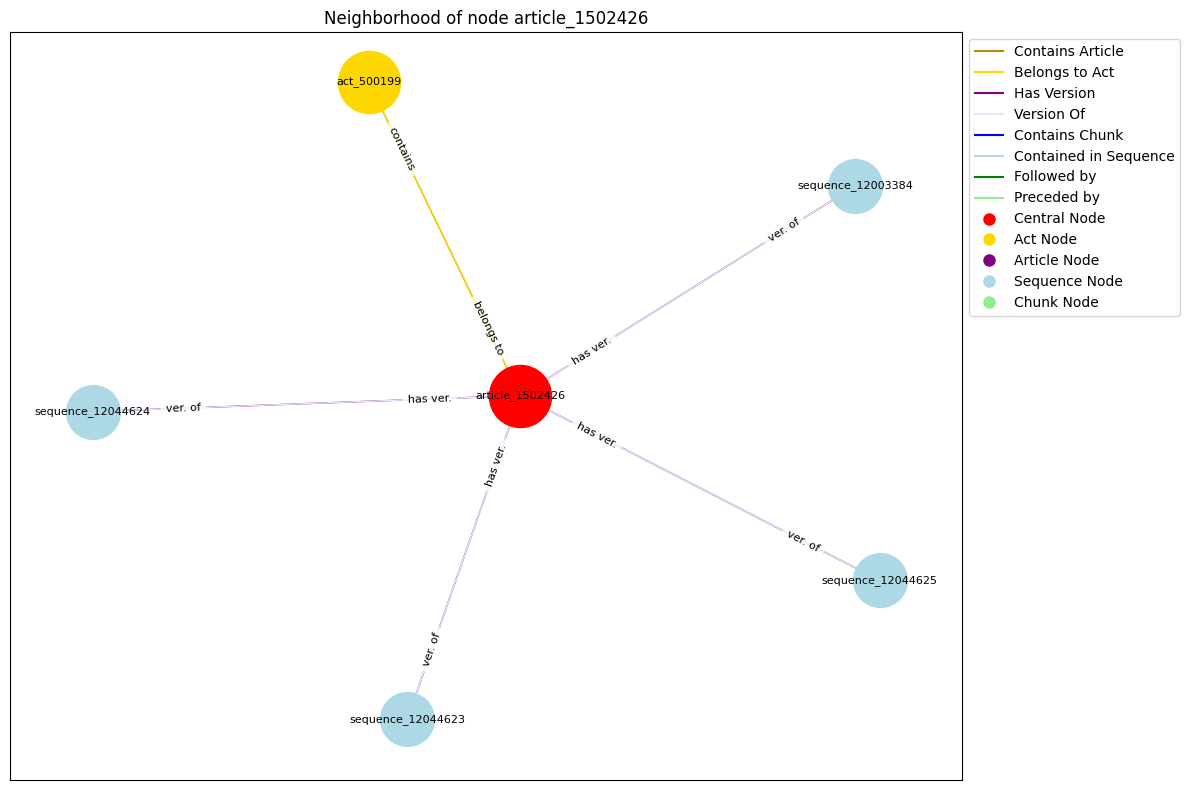

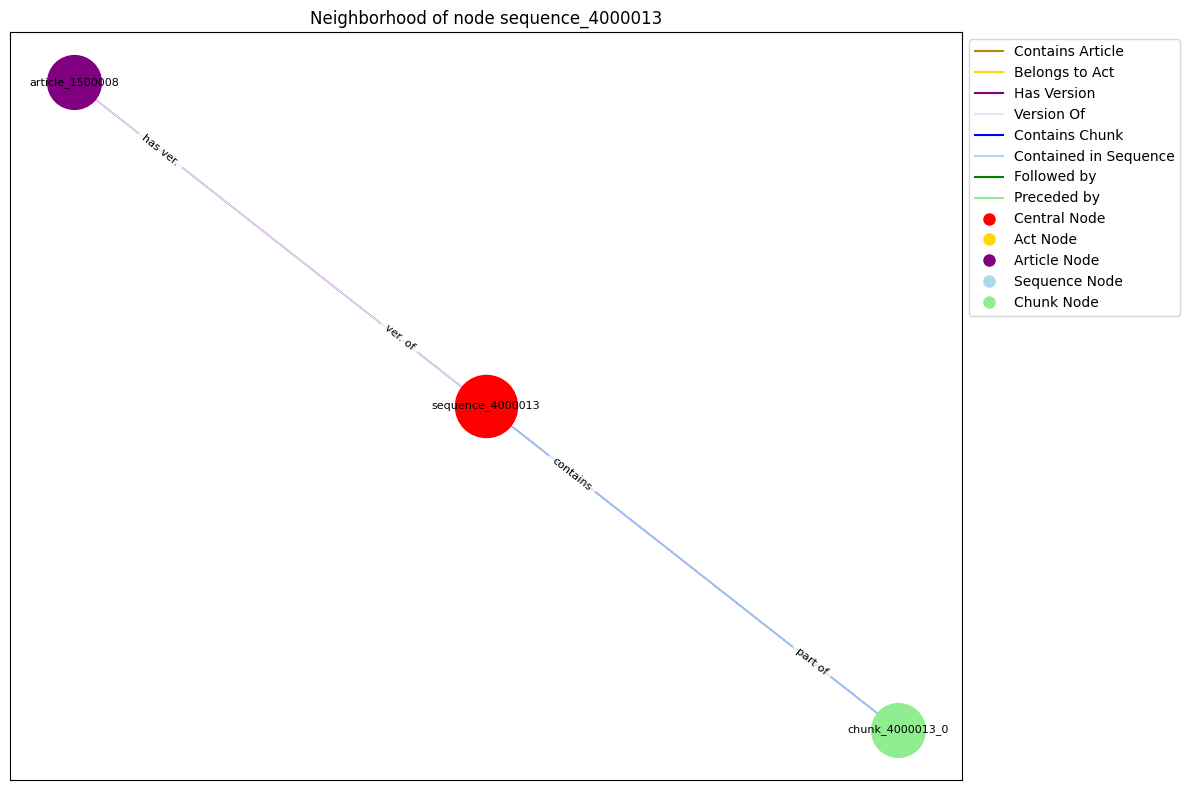

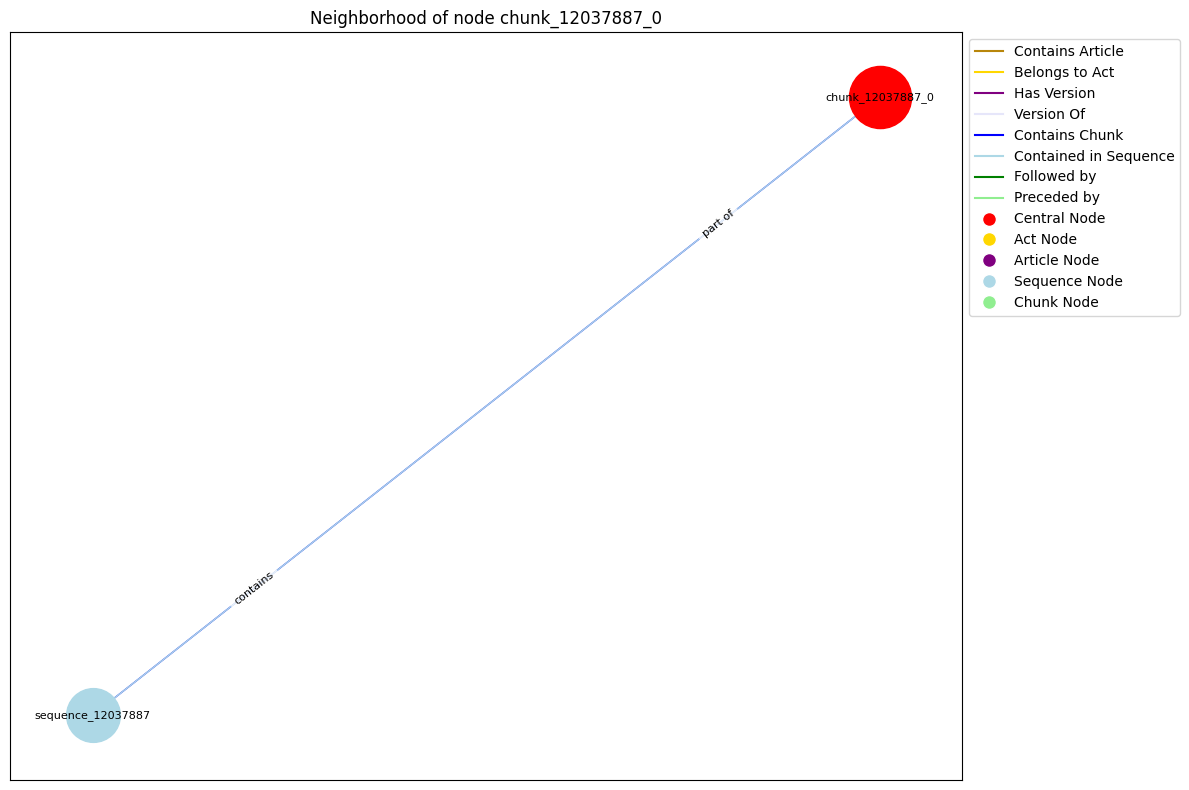

In [20]:
# Plotting the 1-hop neighborhood of different node types

# Act
node_to_visualize = random_act
visualize_node_1hop(graph, node_to_visualize)

# Article
node_to_visualize = random_article
visualize_node_1hop(graph, node_to_visualize)

# Sequence
node_to_visualize = random_sequence
visualize_node_1hop(graph, node_to_visualize)

# Chunk
node_to_visualize = random_chunk
visualize_node_1hop(graph, node_to_visualize)

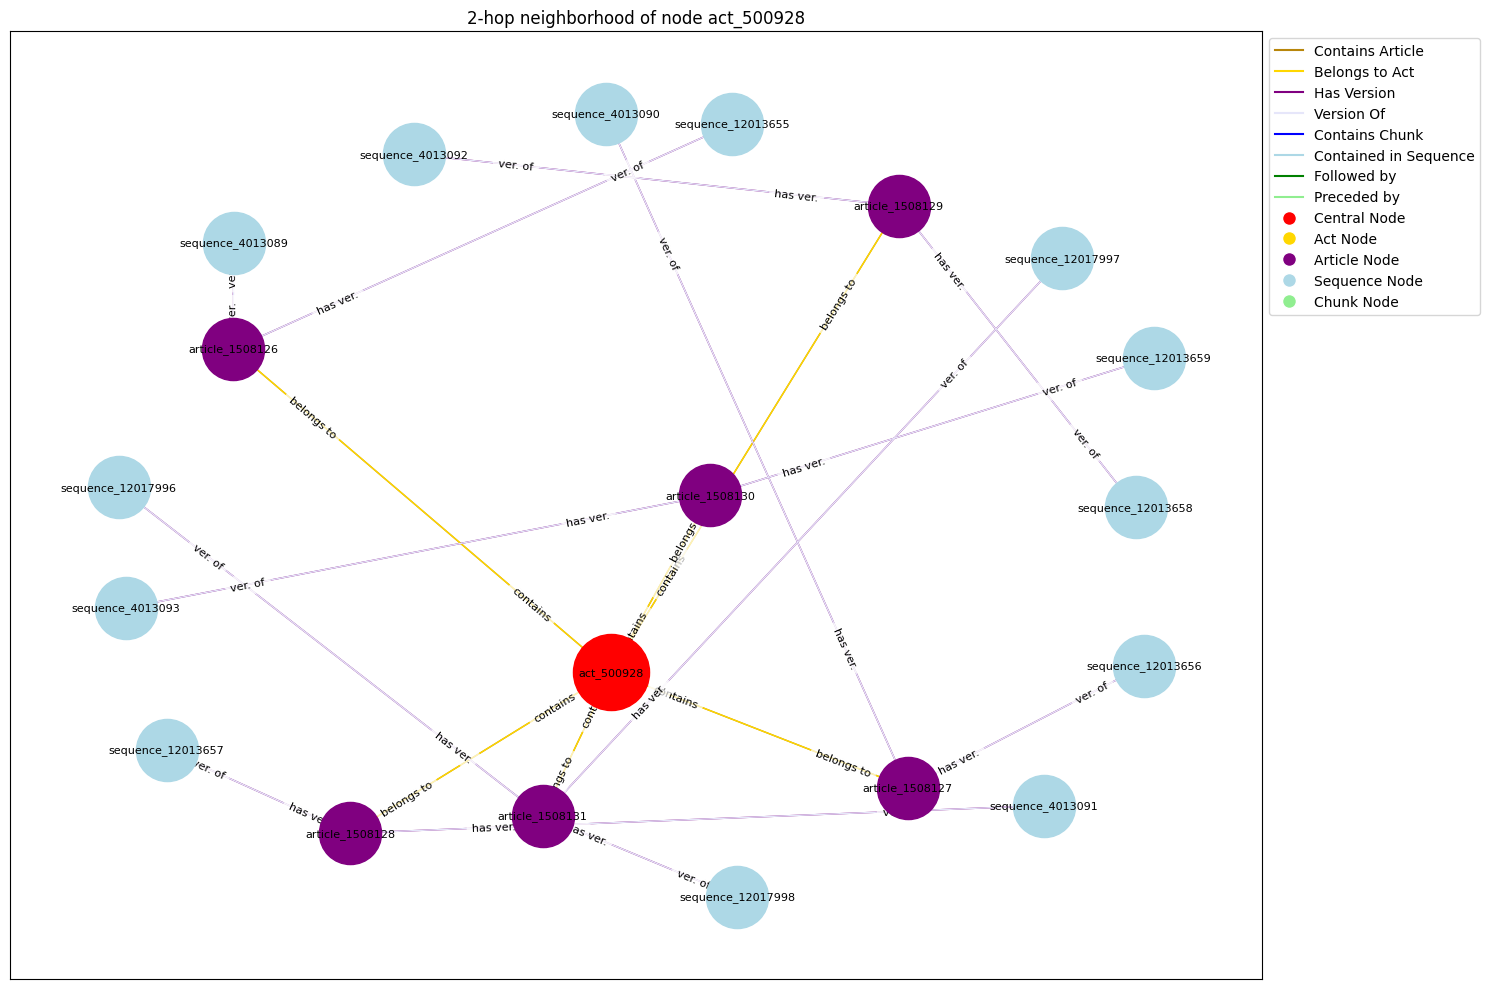

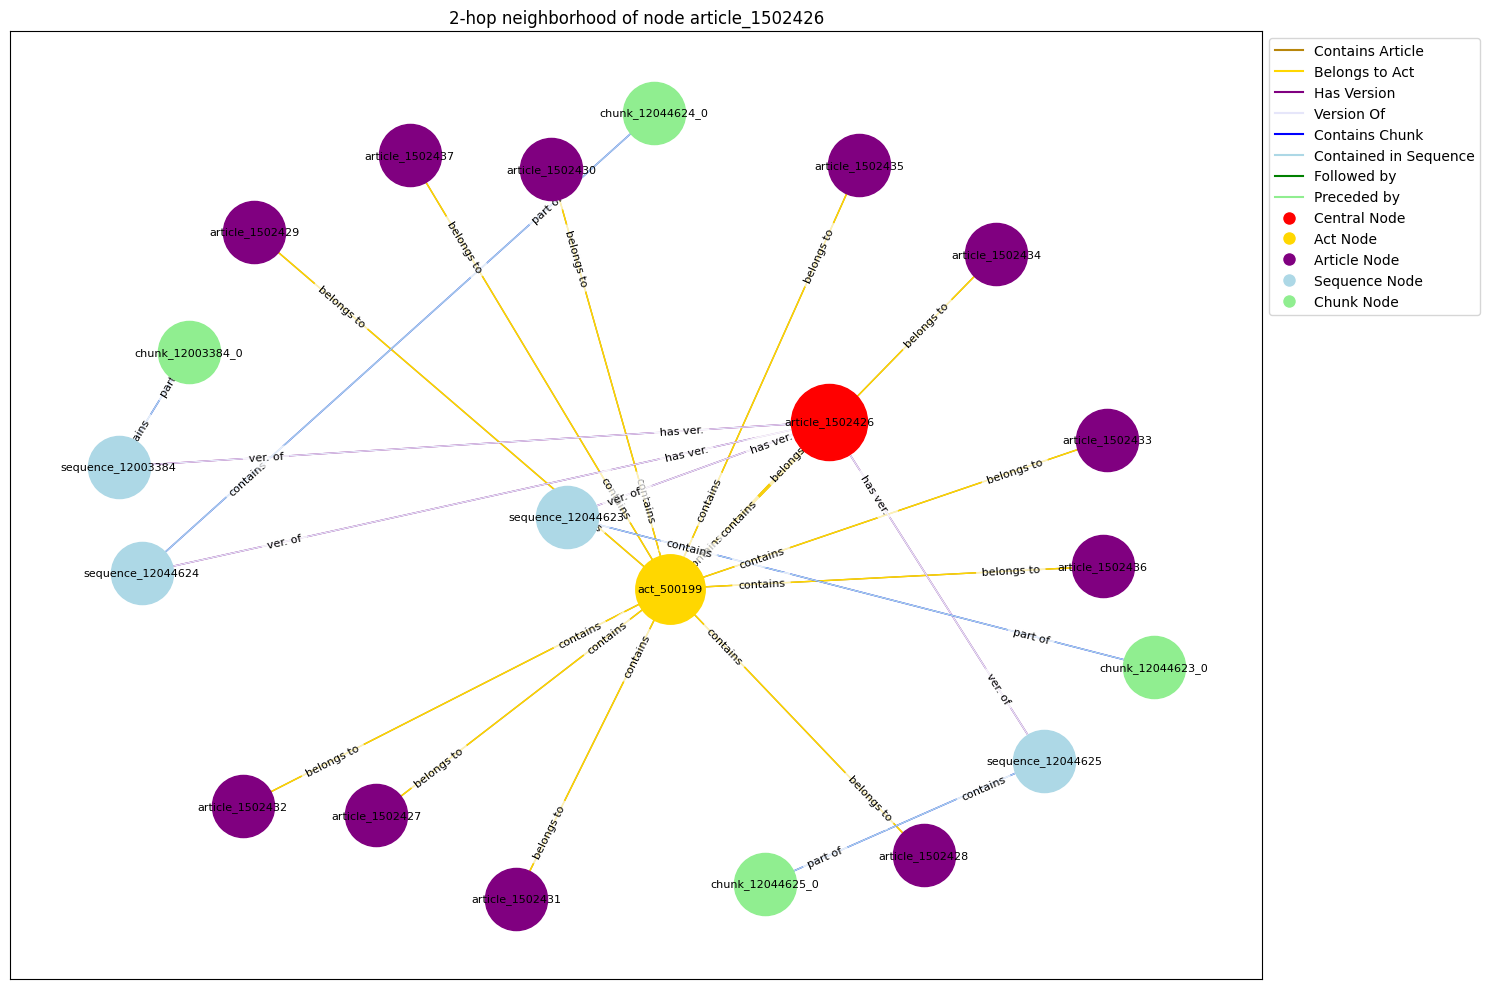

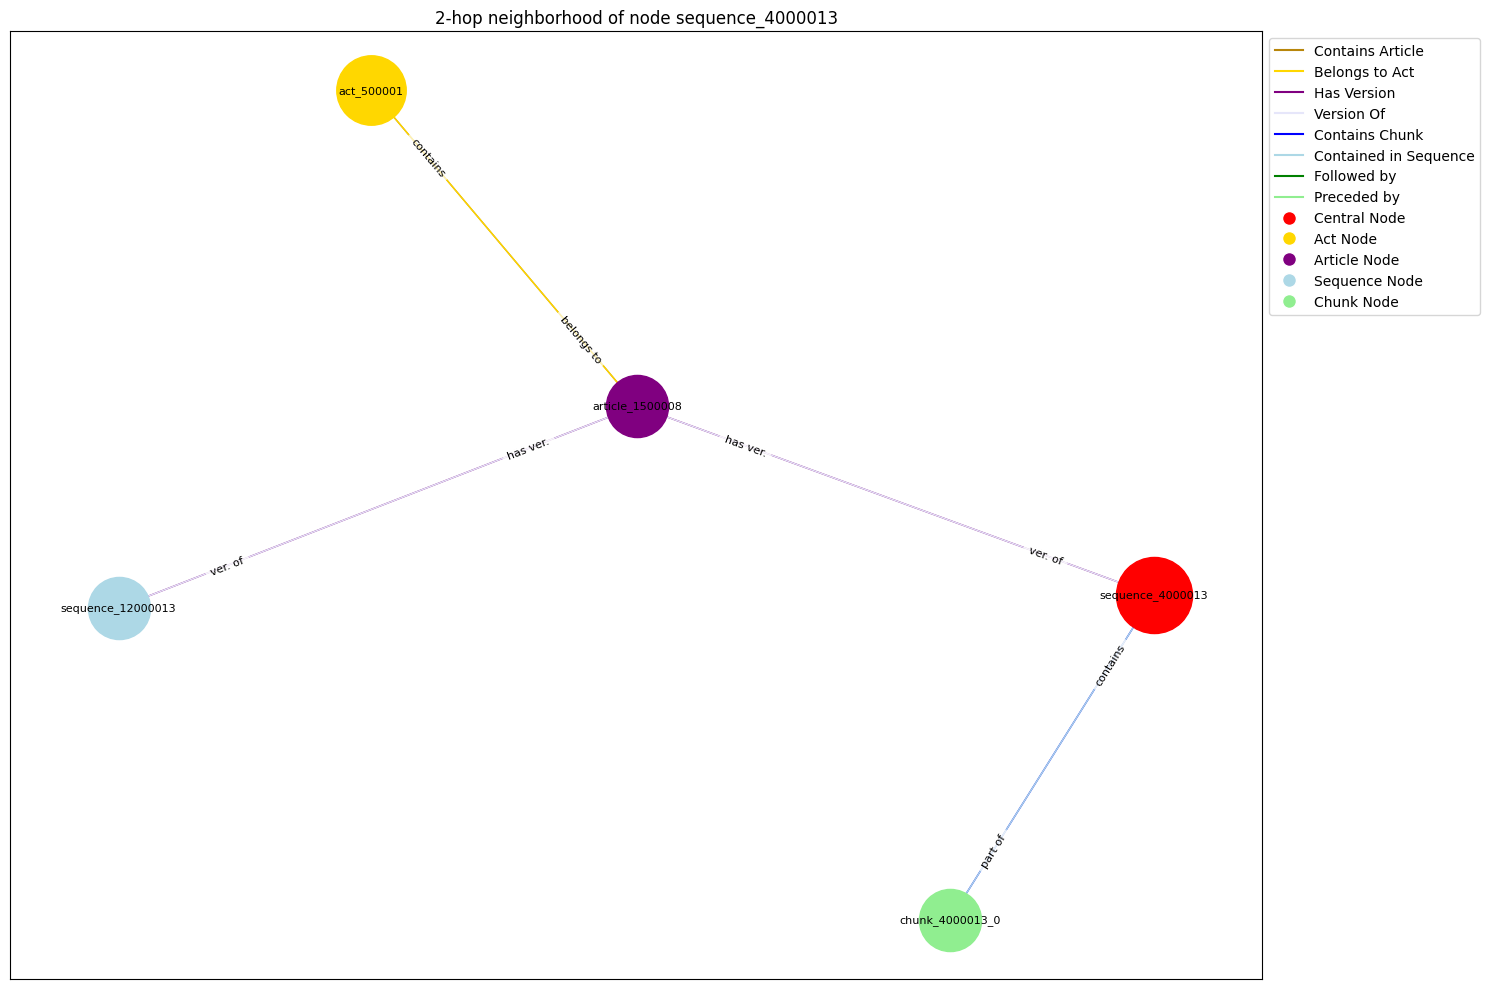

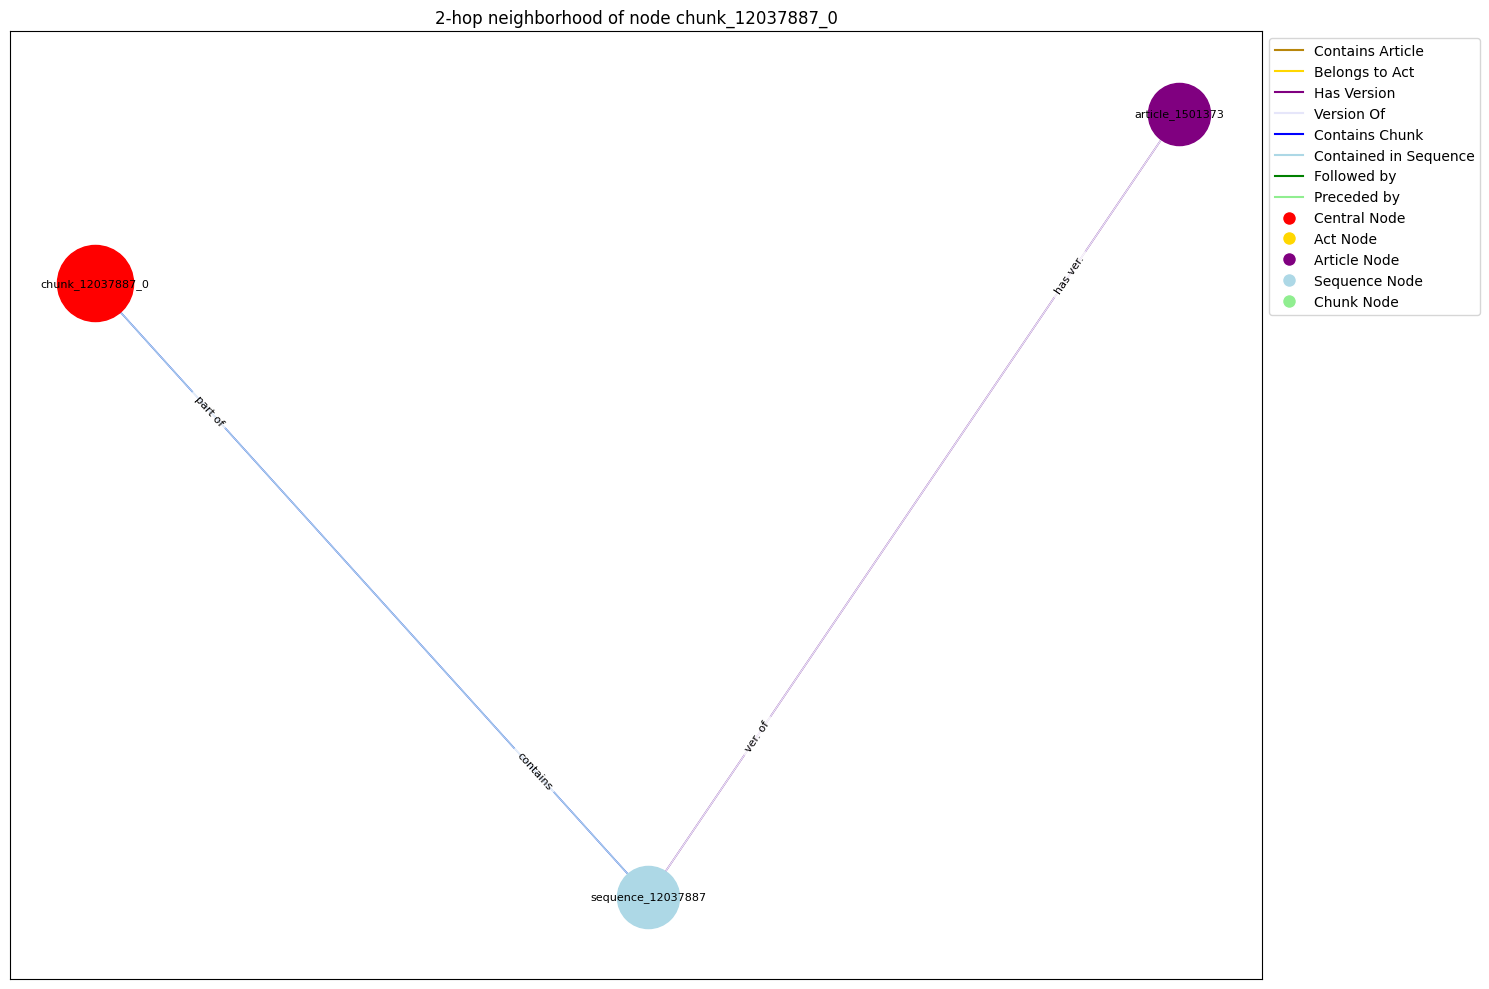

In [21]:
# Plotting the 2-hop neighborhood of different node types

# Act
node_to_visualize = random_act
visualize_node_2hop(graph, node_to_visualize)

# Article
node_to_visualize = random_article
visualize_node_2hop(graph, node_to_visualize)

# Sequence
node_to_visualize = random_sequence
visualize_node_2hop(graph, node_to_visualize)

# Chunk
node_to_visualize = random_chunk
visualize_node_2hop(graph, node_to_visualize)